In [2]:
!pip install -q streamlit

In [2]:
!pip install transformers

In [3]:
import streamlit as st
from PIL import Image
import numpy as np
from torchvision import transforms
import torch

In [5]:

%%writefile app.py
import streamlit as st
from PIL import Image
from torchvision import transforms
import numpy as np

# function to generate caption for the uploaded image
def generate_caption(image):
    caption = "thus"
    return caption

st.title("Image Captioning for Remote Sensing Data")

uploaded_image = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_image is not None:
    image = Image.open(uploaded_image)
    st.image(image, caption="Uploaded Image", use_column_width=True)
    caption = generate_caption(image)
    st.markdown(
        f"<b><p style='font-size:30px; text-align:center; color:yellow;'>Caption: {caption}</p></b>", 
        unsafe_allow_html=True
    )
    
    

Writing app.py


In [6]:
%%writefile model.py
from PIL import Image
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
from torchvision import transforms
import numpy as np


class CaptionModel:
    def __init__(self, ):
        self.model = AutoModelForCausalLM.from_pretrained(f"deepakachu/rsicd_image_captioning")
        self.processor = AutoProcessor.from_pretrained("microsoft/git-base")
    

Writing model.py


In [4]:
from transformers import AutoModelForCausalLM

In [8]:
model = AutoModelForCausalLM.from_pretrained("deepakachu/rsicd_image_captioning")

In [19]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/git-base")

2024-03-09 19:35:47.545734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 19:35:47.545855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 19:35:47.688912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [9]:
# Define the mean and std for normalization
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=MEAN, std=STD)  # Normalize the tensor
])

In [11]:
img_path = r"/kaggle/input/ausssss/geoeye-1-bondi-beach-australia.jpg"

In [12]:
resized_image = Image.open(img_path).resize((224, 224))

In [13]:
torch_tensor = transform(resized_image)
torch_tensor.shape

torch.Size([3, 224, 224])

In [14]:
torch_tensor = torch_tensor.numpy()
torch_tensor = np.resize(torch_tensor,(1,3,224,224))

In [17]:
torch_tensor = torch.from_numpy(torch_tensor)
torch_tensor.shape

torch.Size([1, 3, 224, 224])

In [22]:
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

def denormalize_pixel_values(pixel_values):
    unnormalized_image = (pixel_values.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    
    return Image.fromarray(unnormalized_image)

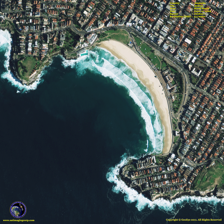

many buildings are close to a port with many boats


In [23]:
generated_ids = model.generate(pixel_values=torch_tensor, max_length=100)
generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)
for px_val, capt in zip(torch_tensor, generated_captions):
    display(denormalize_pixel_values(px_val.cpu()))
    print(capt)

In [24]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("arampacha/rsicd")

# Access the train split
train_dataset = dataset["train"]

# Print some information about the dataset
print(train_dataset.info)

# Print the first few examples in the train split
print(train_dataset[:5])

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/arampacha--rsicd-56e24d6cc63cb9d9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetInfo(description='', citation='', homepage='', license='', features={'filename': Value(dtype='string', id=None), 'captions': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'image': Image(decode=True, id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='json', config_name='default', version=0.0.0, splits={'test': SplitInfo(name='test', num_bytes=60196515, num_examples=1093, dataset_name='parquet'), 'train': SplitInfo(name='train', num_bytes=451093046, num_examples=8734, dataset_name='parquet'), 'valid': SplitInfo(name='valid', num_bytes=57416051, num_examples=1094, dataset_name='parquet')}, download_checksums={'https://huggingface.co/datasets/arampacha/rsicd/resolve/820466c8716e3ccdacde5cb2eb15a2f0f11ccdfe/data/test-00000-of-00001.parquet': {'num_bytes': 55076866, 'checksum': 'e707fd90b59fe22a9a222d48b969226715f3eccf78e2b0f382f0a5565a98acda'}, 'https://huggingface.co/datasets/arampacha/rsicd/resolve/820466c8716e3ccdacde5c

In [26]:
train_dataset

Dataset({
    features: ['filename', 'captions', 'image'],
    num_rows: 8734
})

In [37]:
type(train_dataset["image"][0])

PIL.JpegImagePlugin.JpegImageFile

In [38]:
import os
import random

# Set the output directory
output_dir = "output_images/"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get random indices to select 20 images
random_indices = random.sample(range(len(train_dataset)), 20)

# Iterate through the random indices and save the images
for idx, image in enumerate(train_dataset["image"]):
    if idx not in random_indices:
        continue

    # Save the image
    image_path = os.path.join(output_dir, f"image_{idx}.jpg")
    image.save(image_path)
    print(f"Image saved: {image_path}")


Image saved: output_images/image_20.jpg
Image saved: output_images/image_1047.jpg
Image saved: output_images/image_1048.jpg
Image saved: output_images/image_1089.jpg
Image saved: output_images/image_2278.jpg
Image saved: output_images/image_2318.jpg
Image saved: output_images/image_2657.jpg
Image saved: output_images/image_2842.jpg
Image saved: output_images/image_3019.jpg
Image saved: output_images/image_3088.jpg
Image saved: output_images/image_3099.jpg
Image saved: output_images/image_3211.jpg
Image saved: output_images/image_3580.jpg
Image saved: output_images/image_4131.jpg
Image saved: output_images/image_4467.jpg
Image saved: output_images/image_4772.jpg
Image saved: output_images/image_7397.jpg
Image saved: output_images/image_7470.jpg
Image saved: output_images/image_7492.jpg
Image saved: output_images/image_8611.jpg


In [39]:
import zipfile
import os

# Define the directory to zip
directory_to_zip = "/kaggle/working/output_images"

# Define the zip file name
zip_file_name = "output_images.zip"

# Create a zip file
with zipfile.ZipFile(zip_file_name, "w") as zipf:
    # Iterate over files in the directory and add them to the zip file
    for root, _, files in os.walk(directory_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

# Move the zip file to the output directory
os.rename(zip_file_name, "/kaggle/working/" + zip_file_name)


In [4]:
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
from transformers import AutoModelForCausalLM, AutoProcessor

2024-03-09 21:29:09.400815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 21:29:09.400912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 21:29:09.531795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def denormalize_pixel_values(pixel_values):
    unnormalized_image = (pixel_values.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

In [6]:
# def model_loading(path):
#     state_dict = torch.load(path, map_location=torch.device('gpu'))
#     model_captioner = AutoModelForCausalLM.from_pretrained("deepakachu/rsicd_image_captioning")
#     model_captioner.load_state_dict(state_dict)
#     model_captioner.to(device)
#     return model_captioner
def model_loading():
#     state_dict = torch.load(path, map_location=torch.device('gpu'))
    model_captioner = AutoModelForCausalLM.from_pretrained("deepakachu/rsicd_image_captioning")
#     model_captioner.load_state_dict(state_dict)
    model_captioner.to(device)
    return model_captioner

In [7]:
def make_inference(image, model):
    # Resize the image before applying the transformation
    resized_image = image.resize((224, 224))
    # Apply the transformation
    torch_tensor = transform(resized_image)
    # Process the single image
    pixel_values = torch_tensor.unsqueeze(0).to(device)  # Add batch dimension
    # Generate caption
    generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    # Display and print results
    return generated_caption

In [8]:
processor = AutoProcessor.from_pretrained("microsoft/git-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=MEAN, std=STD)  # Normalize the tensor
])

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [9]:
from datasets import load_dataset
model = model_loading()
dataset = load_dataset("arampacha/rsicd")
make_inference(dataset['test'][0]['image'], model)

config.json:   0%|          | 0.00/859 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/arampacha--rsicd-56e24d6cc63cb9d9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

'many pieces of farmlands are together'

In [10]:
dataset

DatasetDict({
    valid: Dataset({
        features: ['filename', 'captions', 'image'],
        num_rows: 1094
    })
    train: Dataset({
        features: ['filename', 'captions', 'image'],
        num_rows: 8734
    })
    test: Dataset({
        features: ['filename', 'captions', 'image'],
        num_rows: 1093
    })
})

In [11]:
make_inference(dataset['valid'][0]['image'], model)

'many pieces of farmlands are together'

In [12]:
dataset['valid'][0]['filename']

'rsicd_images/airport_61.jpg'

In [13]:
import pandas as pd
filenames = []
generated_captions = []
for i in range(len(dataset['valid'])):
    if(i%10 == 0):
        print(i)
    filenames.append(dataset['valid'][i]['filename'])
    generated_captions.append(make_inference(dataset['valid'][i]['image'], model))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090


In [14]:
len(filenames), len(generated_captions)

(1094, 1094)

In [15]:
df = pd.DataFrame({"filenames": filenames, "generated_captions": generated_captions})
df

,filenames,generated_captions
0,rsicd_images/airport_61.jpg,many pieces of farmlands are together
1,rsicd_images/airport_62.jpg,many buildings are close to a port with many b...
2,rsicd_images/airport_63.jpg,a white plane is near a terminal in an airport
3,rsicd_images/airport_64.jpg,some buildings and bare land are around a whit...
4,rsicd_images/airport_65.jpg,many buildings are close to a large building
...,...,...
1089,rsicd_images/00912.jpg,a football field is near a road with green trees
1090,rsicd_images/00913.jpg,a playground is surrounded by many green trees...
1091,rsicd_images/00917.jpg,a baseball field is surrounded by many buildin...
1092,rsicd_images/00919.jpg,a football field is close to several green tre...


In [16]:
df.to_csv("valid_captions.csv")